In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math as m


In [3]:
resolution = 5
phi = np.random.rand()*2*np.pi
xAxis = np.arange(0, 1, 1/resolution)
gratingP = 1

#signal
signal = np.sin(2*np.pi*xAxis/gratingP + phi)+1
#reduce the contrast to realistic numbers
LoseContrast = signal + 2
signalP = np.random.poisson(LoseContrast)

#error bars for LoseContrast
errorBars = np.ones(len(LoseContrast))*(np.max(LoseContrast) - np.min(LoseContrast))* 0.2

#truthy signal
xT = np.linspace(0, gratingP, 1000)
signalT = np.sin(2*np.pi*xT/gratingP + phi)+3

print(xAxis)

[0.  0.2 0.4 0.6 0.8]


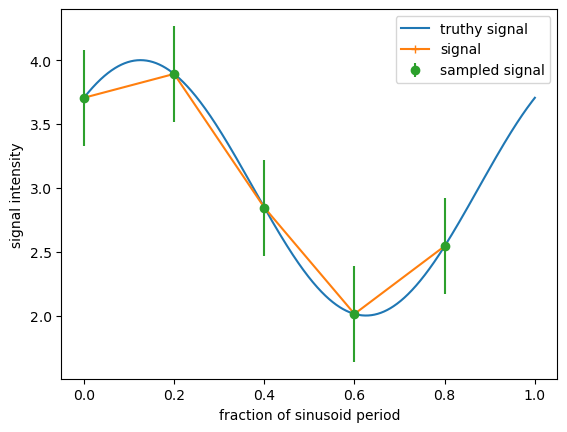

In [4]:
plt.plot(xT, signalT, label='truthy signal')
plt.plot(xAxis, LoseContrast,'+-',label='signal')
#add error bars
plt.errorbar(xAxis, LoseContrast, yerr=errorBars, fmt='o', label='sampled signal')
plt.xlabel('fraction of sinusoid period')
plt.ylabel('signal intensity')
plt.legend()

In [5]:
#calculate the error with discrete sampling a sine wave n times
#this calculates what fraction of the full amplitude is recorded by the discrete sampling
tests = 10000
phi =  np.random.rand(tests)*2*np.pi
samples = 25
expectCon = np.zeros(samples)

#generated average maxMin difference
minMaxAvg = np.zeros(samples)
minMaxMin = np.zeros(samples)
sampleArr = np.arange(0, samples, 1)

for i in range(1, samples):
    #table for 1000 runs
    results = np.zeros(tests)
    for k in range(0, tests):
        sineArr = np.zeros(i)
        for j in range(0, i):
            sineArr[j] = np.sin(2*np.pi*j/i + phi[k])+3
        max = np.max(sineArr)
        min = np.min(sineArr)
        results[k] = max - min

    minMaxAvg[i] = np.mean(results)/2
    minMaxMin[i] = np.min(results)/2
            


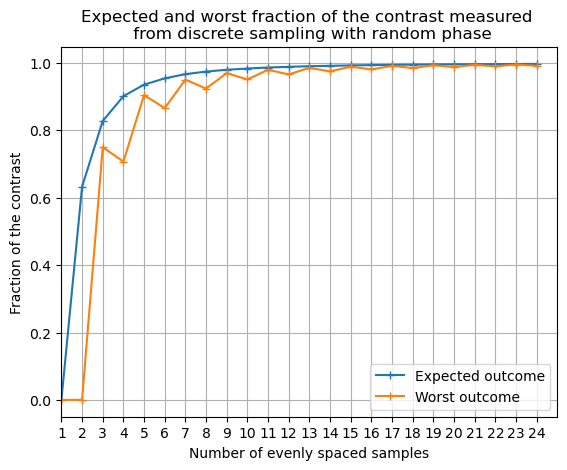

[0.         0.         0.63287216 0.82770307 0.90129654 0.93568001
 0.95422236 0.96685685 0.97433084 0.97981894 0.98347413 0.98649338
 0.98857187 0.99029708 0.99151216 0.99269844 0.99367789 0.99433601
 0.9949627  0.99543227 0.99590766 0.99627309 0.99655612 0.99689056
 0.99712527]
[0.00000000e+00 0.00000000e+00 3.47587460e-04 7.50010084e-01
 7.07112297e-01 9.04526139e-01 8.66042219e-01 9.50500799e-01
 9.23884804e-01 9.69850293e-01 9.51058002e-01 9.79746803e-01
 9.65927845e-01 9.85472274e-01 9.74932724e-01 9.89075346e-01
 9.80789792e-01 9.91487838e-01 9.84808523e-01 9.93181007e-01
 9.87689561e-01 9.94416666e-01 9.89823304e-01 9.95343576e-01
 9.91445194e-01]


In [6]:
#plot the above for the expected outcome and the worst possible
plt.plot(sampleArr, minMaxAvg, label='Expected outcome', marker='+')
plt.plot(sampleArr, minMaxMin, label='Worst outcome', marker='+')
plt.xticks(np.arange(0,len(sampleArr),1))
plt.grid(True)
plt.legend()
plt.xlim(1, len(sampleArr))
plt.ylabel('Fraction of the contrast')
plt.xlabel('Number of evenly spaced samples')
plt.title('Expected and worst fraction of the contrast measured \n from discrete sampling with random phase')
plt.show()
print(minMaxAvg)
print(minMaxMin)

#for two samples we are at the Nyquist limit therefore the worst is 0, 
#but the expected value difference of the samples is 2/3.

In [7]:
###########
#Now we can figure out the time we need to wait for each sample then multiply by the number of samples

In [8]:
def N(rate, time):
    return rate*time

def contrast(max, min):
    return (max-min)/(max+min)

def maxMin(contrast):
    return (1+contrast)/(1-contrast)

#sigma to percentile
def sigmaP(sigma):
    return m.erf(sigma/np.sqrt(2))

def timeToWait(samples, rate, sigma, contrast):
    x = (1-sigmaP(sigma))*(maxMin(contrast)-1)*(minMaxAvg[samples])
    norm = samples/rate
    return norm/x**2

def extremeTimeToWait(samples, rate, sigma, contrast):
    x = (1-sigmaP(sigma))*(maxMin(contrast)-1)*(minMaxMin[samples])
    norm = samples/rate
    return norm/x**2

#alt method

def timeToWait(samples, rate, sigma, contrast):
    x = (1-1/sigma)*(maxMin(contrast)-1)*(minMaxAvg[samples])
    norm = samples/rate
    return norm/x**2

def extremeTimeToWait(samples, rate, sigma, contrast):
    x = (1-1/sigma)*(maxMin(contrast)-1)*(minMaxMin[samples])
    norm = samples/rate
    return norm/x**2

#give the length in mm, speed in m/s and the time constant in us
def expDecay(lengthmm, speedMS, timeconstantUs):
    length = lengthmm/1000
    time = length / speedMS
    timeconstantS = timeconstantUs*1e-6
    return np.exp(-time/timeconstantS)

#give the single side size of the square detector in mm and the distance away in cm
def solidAngle(detectorSizeMM, distAwayCM):
    detArea = (detectorSizeMM/1000)**2 #get them into metres
    distAway = distAwayCM/100
    return detArea/(4*np.pi*distAway**2)*2 #times 2 for full telescope


In [12]:
samplePerSin = 5 
MuRate = 0.02 #per second
detectorSize = 100 #mm
distanceAway = 5.5 #cm this should be the further detector array
legnthInty = 2.5 + 1.5#mm
muvelocity = 2175 #m/s
sigma = 5 #3 sigma threshold i.e. 95th percentile
signal2Noise = 0.05
inherentContrast = 0.5

solidRate = MuRate * solidAngle(detectorSize, distanceAway)
#take into account expdecay before detectors
realRate = solidRate * expDecay(legnthInty, muvelocity, 2.2)
contrast = signal2Noise * inherentContrast
print(timeToWait(samplePerSin, realRate, sigma, contrast)/3600)

206.64452055150392


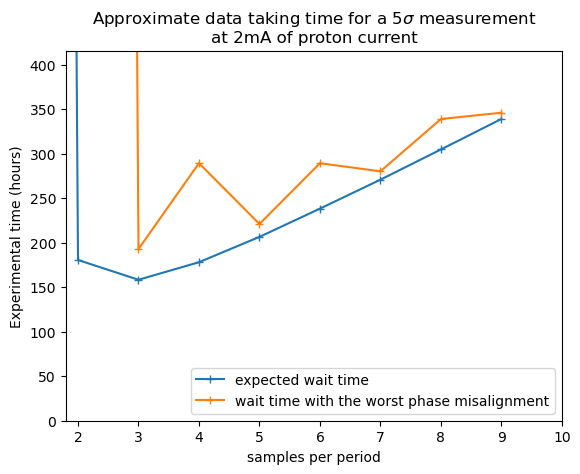

In [13]:
limit = 10
time = np.zeros(limit)
extremeTime = np.zeros(limit)
for samples in range(2,limit):
    time[samples] = timeToWait(samples, realRate, sigma, contrast)/3600
    extremeTime[samples] = extremeTimeToWait(samples, realRate, sigma, contrast)/3600

extremeTime[2] = 10000
time[1] = 10000

plt.plot(time, '+-', label='expected wait time')
plt.plot(extremeTime, '+-', label='wait time with the worst phase misalignment')
plt.xlabel('samples per period')
plt.ylabel('Experimental time (hours)')
plt.xticks(np.arange(0, limit+1, 1))
plt.xlim(1.8, limit)
plt.ylim(0, extremeTime[-1]*1.2)
plt.title('Approximate data taking time for a 5$\sigma$ measurement \n' 
          'at 2mA of proton current')
'''plt.title('Approximate data taking time for a 5$\sigma$ measurement \n' 
          'at 2mA of proton current. Assumptions: \n'
          f'Muonium rate: {MuRate} per second, \n'
            f'Detector size: {detectorSize}mm, \n'
            f'Distance away: {distanceAway}cm, \n'
            f'Length of interferometer: {legnthInty}mm, $\therefore$ detection region position: {legnthInty + 1.5}mm\n'
            f'Signal to noise ratio: {signal2Noise}, \n'
            f'Inherent contrast: {inherentContrast} \n'
            'as well as previously characterised muonium beam parameters')'''

#legend in bottom right corner
plt.legend(loc='lower right')

In [11]:
#this plot shows the length of time we need to wait to achieve an 'n' sigma result between distinguising 
# the the largest and smallest data points in the oscillating signal.